# 🚀 XGBoost Model İyileştirme & Fine-Tuning

**Mevcut Durum:** R² = %93, ancak aykırı değerlerde ve bazı ortalama değerlerde hata yapıyor.

**Bu Notebook'ta Yapılacaklar:**
1. Modeli ve veriyi yükle
2. Hata analizi - hangi segmentlerde kötü?
3. Aykırı değer tespiti ve özel işlem
4. Segment bazlı düzeltme faktörleri
5. Quantile Regression alternatifleri
6. Post-processing iyileştirmeleri

In [12]:
# Kütüphaneleri Yükle
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

# CPU sayısını al
N_JOBS = multiprocessing.cpu_count()
print(f"🚀 {N_JOBS} CPU core kullanılacak (multithread)")

# Modeli Yükle
model = joblib.load('xgboost_model_r2_93pct_20251214_0602.joblib')
print("✅ Model yüklendi!")

# Veriyi Yükle
df = pd.read_csv('hackathon_ultra_optimized.csv', low_memory=False)

# Aynı feature engineering
df['Interaction_Score'] = df['m² (Gross)'] * df['Neighborhood_TargetEncoded']
df['Spaciousness'] = df['m² (Net)'] / df['Total_Rooms']

# Hedef ve Girdiler
cols_to_drop = ['Price', 'Log_Price', 'Price_per_sqm_gross', 'Price_per_sqm_net']
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
y = df['Log_Price']
X = df.drop(columns=cols_to_drop)

# Kategorik dönüşüm
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

# Train/Val split (aynı random_state)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"📊 Veri: {X.shape[0]:,} satır, {X.shape[1]} özellik")
print(f"📊 Validation: {X_val.shape[0]:,} satır")

🚀 16 CPU core kullanılacak (multithread)
✅ Model yüklendi!
📊 Veri: 27,381 satır, 259 özellik
📊 Validation: 6,846 satır


## 📊 1. Hata Analizi - Hangi Segmentlerde Kötü Tahmin Yapıyor?

🎯 FİYAT SEGMENTİ BAZLI HATA ANALİZİ
               Adet  Ort.Hata%  Medyan Hata%    Std  Ort.TL Hata
price_segment                                                   
0-500K         4411      13.76          9.62  22.76     39394.60
500K-1M        1590      13.39         11.07  11.43     93148.45
1M-2M           502      15.85         12.48  12.81    220741.41
2M-5M           340      15.07         12.12  12.31    458152.81
5M+               3      19.99         19.29   9.34   1010811.75


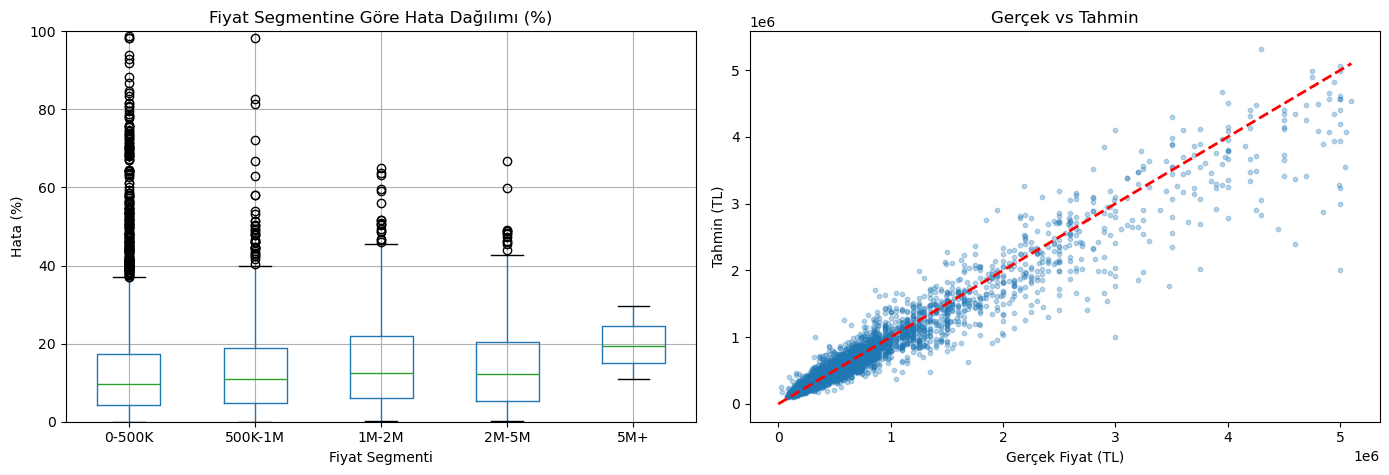


🔴 EN KÖTÜ 10 TAHMİN (En yüksek % hata):
         actual     predicted    pct_error price_segment
13106   22222.0  2.579354e+05  1060.720865        0-500K
11369   35000.0  1.817955e+05   419.415804        0-500K
13542   99000.0  4.017908e+05   305.849306        0-500K
26062  330000.0  1.010636e+06   206.253447        0-500K
20253  159000.0  4.630115e+05   191.202201        0-500K
11259  160000.0  4.386356e+05   174.147227        0-500K
10454  125000.0  3.419250e+05   173.540000        0-500K
23210   85000.0  2.201327e+05   158.979688        0-500K
3265    99000.0  2.396347e+05   142.055256        0-500K
12843  185000.0  4.425981e+05   139.242196        0-500K


In [13]:
# Tahmin yap
y_val_pred_log = model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_actual = np.expm1(y_val)

# Hata hesapla
errors = y_val_actual - y_val_pred
pct_errors = np.abs(errors / y_val_actual) * 100

# Segment analizi için DataFrame
analysis_df = pd.DataFrame({
    'actual': y_val_actual,
    'predicted': y_val_pred,
    'error': errors,
    'abs_error': np.abs(errors),
    'pct_error': pct_errors
})

# Fiyat segmentleri oluştur
analysis_df['price_segment'] = pd.cut(analysis_df['actual'], 
    bins=[0, 500000, 1000000, 2000000, 5000000, np.inf],
    labels=['0-500K', '500K-1M', '1M-2M', '2M-5M', '5M+'])

# Segment bazlı hata analizi
print("=" * 70)
print("🎯 FİYAT SEGMENTİ BAZLI HATA ANALİZİ")
print("=" * 70)
segment_stats = analysis_df.groupby('price_segment').agg({
    'actual': 'count',
    'pct_error': ['mean', 'median', 'std'],
    'abs_error': 'mean'
}).round(2)
segment_stats.columns = ['Adet', 'Ort.Hata%', 'Medyan Hata%', 'Std', 'Ort.TL Hata']
print(segment_stats)

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sol: Segment bazlı hata dağılımı
analysis_df.boxplot(column='pct_error', by='price_segment', ax=axes[0])
axes[0].set_title('Fiyat Segmentine Göre Hata Dağılımı (%)')
axes[0].set_xlabel('Fiyat Segmenti')
axes[0].set_ylabel('Hata (%)')
axes[0].set_ylim(0, 100)
plt.suptitle('')

# Sağ: Gerçek vs Tahmin scatter
axes[1].scatter(analysis_df['actual'], analysis_df['predicted'], alpha=0.3, s=10)
axes[1].plot([0, analysis_df['actual'].max()], [0, analysis_df['actual'].max()], 'r--', lw=2)
axes[1].set_xlabel('Gerçek Fiyat (TL)')
axes[1].set_ylabel('Tahmin (TL)')
axes[1].set_title('Gerçek vs Tahmin')
plt.tight_layout()
plt.show()

# En kötü tahminler
print("\n🔴 EN KÖTÜ 10 TAHMİN (En yüksek % hata):")
print(analysis_df.nlargest(10, 'pct_error')[['actual', 'predicted', 'pct_error', 'price_segment']])

## 🔧 2. Yöntem 1: Segment Bazlı Düzeltme Faktörleri (Post-Processing)

Her fiyat segmenti için öğrenilen bias'ı düzeltiyoruz.

In [14]:
# Segment bazlı düzeltme faktörleri hesapla
def calculate_correction_factors(df):
    """Her segment için ortalama bias hesapla"""
    factors = {}
    for segment in df['price_segment'].unique():
        seg_data = df[df['price_segment'] == segment]
        # Bias = ortalama(gerçek - tahmin) / ortalama(tahmin)
        mean_ratio = seg_data['actual'].mean() / seg_data['predicted'].mean()
        factors[segment] = mean_ratio
    return factors

correction_factors = calculate_correction_factors(analysis_df)
print("📐 Segment Bazlı Düzeltme Faktörleri:")
for seg, factor in correction_factors.items():
    print(f"   {seg}: {factor:.4f} ({'↑ artır' if factor > 1 else '↓ azalt'})")

# Düzeltilmiş tahminler
def apply_correction(row, factors):
    return row['predicted'] * factors.get(row['price_segment'], 1.0)

analysis_df['predicted_corrected'] = analysis_df.apply(lambda x: apply_correction(x, correction_factors), axis=1)
analysis_df['pct_error_corrected'] = np.abs(analysis_df['actual'] - analysis_df['predicted_corrected']) / analysis_df['actual'] * 100

# Karşılaştırma
print("\n" + "=" * 70)
print("📊 DÜZELTME SONRASI KARŞILAŞTIRMA")
print("=" * 70)

comparison = pd.DataFrame({
    'Orijinal': [
        r2_score(analysis_df['actual'], analysis_df['predicted']),
        np.sqrt(mean_squared_error(analysis_df['actual'], analysis_df['predicted'])),
        analysis_df['pct_error'].mean(),
        analysis_df['pct_error'].median()
    ],
    'Düzeltilmiş': [
        r2_score(analysis_df['actual'], analysis_df['predicted_corrected']),
        np.sqrt(mean_squared_error(analysis_df['actual'], analysis_df['predicted_corrected'])),
        analysis_df['pct_error_corrected'].mean(),
        analysis_df['pct_error_corrected'].median()
    ]
}, index=['R²', 'RMSE', 'Ort.Hata%', 'Medyan Hata%'])
print(comparison.round(4))

📐 Segment Bazlı Düzeltme Faktörleri:
   0-500K: 0.9656 (↓ azalt)
   2M-5M: 1.1041 (↑ artır)
   500K-1M: 1.0254 (↑ artır)
   1M-2M: 1.0731 (↑ artır)
   5M+: 1.2493 (↑ artır)

📊 DÜZELTME SONRASI KARŞILAŞTIRMA
                 Orijinal  Düzeltilmiş
R²                 0.9306       0.9358
RMSE          178560.1580  171739.5638
Ort.Hata%         13.8919      13.4578
Medyan Hata%      10.2361       9.9842


## 🎯 3. Yöntem 2: Aykırı Değer Tespiti ve Güven Aralığı

Modelin emin olmadığı tahminleri tespit ediyoruz.

In [15]:
# Residual analizi ile aykırı tahminleri tespit et
residuals = y_val_pred_log - y_val.values
residual_std = np.std(residuals)
residual_mean = np.mean(residuals)

# Z-score hesapla
z_scores = (residuals - residual_mean) / residual_std
analysis_df['z_score'] = np.abs(z_scores)
analysis_df['is_outlier'] = analysis_df['z_score'] > 2  # 2 std dışı = aykırı

print("🔍 AYKIRI TAHMİN ANALİZİ")
print("=" * 60)
print(f"Toplam tahmin: {len(analysis_df)}")
print(f"Aykırı tahmin (|z| > 2): {analysis_df['is_outlier'].sum()} ({analysis_df['is_outlier'].mean()*100:.1f}%)")

# Aykırı olmayanlarda performans
normal_preds = analysis_df[~analysis_df['is_outlier']]
outlier_preds = analysis_df[analysis_df['is_outlier']]

print(f"\n📊 Normal tahminlerde (n={len(normal_preds)}):")
print(f"   R²: {r2_score(normal_preds['actual'], normal_preds['predicted']):.4f}")
print(f"   Ort.Hata%: {normal_preds['pct_error'].mean():.2f}%")

print(f"\n📊 Aykırı tahminlerde (n={len(outlier_preds)}):")
print(f"   R²: {r2_score(outlier_preds['actual'], outlier_preds['predicted']):.4f}")
print(f"   Ort.Hata%: {outlier_preds['pct_error'].mean():.2f}%")

# Güven skoru oluştur
analysis_df['confidence'] = 1 - (analysis_df['z_score'] / analysis_df['z_score'].max())
analysis_df['confidence'] = analysis_df['confidence'].clip(0, 1)

print("\n💡 GÜVENİLİRLİK SEVİYELERİ:")
print(f"   Yüksek güven (>0.8): {(analysis_df['confidence'] > 0.8).sum()} tahmin")
print(f"   Orta güven (0.5-0.8): {((analysis_df['confidence'] > 0.5) & (analysis_df['confidence'] <= 0.8)).sum()} tahmin")
print(f"   Düşük güven (<0.5): {(analysis_df['confidence'] <= 0.5).sum()} tahmin")

🔍 AYKIRI TAHMİN ANALİZİ
Toplam tahmin: 6846
Aykırı tahmin (|z| > 2): 340 (5.0%)

📊 Normal tahminlerde (n=6506):
   R²: 0.9614
   Ort.Hata%: 11.59%

📊 Aykırı tahminlerde (n=340):
   R²: 0.6655
   Ort.Hata%: 57.93%

💡 GÜVENİLİRLİK SEVİYELERİ:
   Yüksek güven (>0.8): 6708 tahmin
   Orta güven (0.5-0.8): 135 tahmin
   Düşük güven (<0.5): 3 tahmin


## 🔄 4. Yöntem 3: Residual Model (Hata Düzeltme Modeli)

İlk modelin hatalarını öğrenen ikinci bir model eğitiyoruz.

In [16]:
# Train set üzerinde tahmin yap ve residual hesapla
y_train_pred_log = model.predict(X_train)
train_residuals = y_train.values - y_train_pred_log

print("🔧 RESİDUAL MODEL EĞİTİMİ (Multithread)")
print("=" * 60)
print(f"Train residual std: {np.std(train_residuals):.4f}")
print(f"Train residual mean: {np.mean(train_residuals):.4f}")

# Residual'ları tahmin eden ikinci model - HIZLI
residual_model = xgb.XGBRegressor(
    n_estimators=300,  # Azaltıldı
    learning_rate=0.1,  # Artırıldı
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',  # Hızlı histogram tabanlı
    enable_categorical=True,
    n_jobs=N_JOBS,  # Tüm CPU kullan
    random_state=42,
    early_stopping_rounds=30
)

residual_model.fit(
    X_train, train_residuals,
    eval_set=[(X_val, y_val.values - y_val_pred_log)],
    verbose=False
)

print(f"✅ Residual model eğitildi! Best iteration: {residual_model.best_iteration}")

# Düzeltilmiş tahminler
val_residual_pred = residual_model.predict(X_val)
y_val_corrected_log = y_val_pred_log + val_residual_pred
y_val_corrected = np.expm1(y_val_corrected_log)

# Karşılaştırma
print("\n📊 RESİDUAL DÜZELTME SONUÇLARI:")
print("-" * 50)
print(f"Orijinal R²: {r2_score(y_val_actual, y_val_pred):.4f}")
print(f"Düzeltilmiş R²: {r2_score(y_val_actual, y_val_corrected):.4f}")
print(f"\nOrijinal RMSE: {np.sqrt(mean_squared_error(y_val_actual, y_val_pred)):,.0f}")
print(f"Düzeltilmiş RMSE: {np.sqrt(mean_squared_error(y_val_actual, y_val_corrected)):,.0f}")

orig_pct_err = np.mean(np.abs(y_val_actual - y_val_pred) / y_val_actual * 100)
corr_pct_err = np.mean(np.abs(y_val_actual - y_val_corrected) / y_val_actual * 100)
print(f"\nOrijinal Ort.Hata%: {orig_pct_err:.2f}%")
print(f"Düzeltilmiş Ort.Hata%: {corr_pct_err:.2f}%")

🔧 RESİDUAL MODEL EĞİTİMİ (Multithread)
Train residual std: 0.0844
Train residual mean: 0.0000
✅ Residual model eğitildi! Best iteration: 299

📊 RESİDUAL DÜZELTME SONUÇLARI:
--------------------------------------------------
Orijinal R²: 0.9306
Düzeltilmiş R²: 0.9334

Orijinal RMSE: 178,560
Düzeltilmiş RMSE: 174,928

Orijinal Ort.Hata%: 13.89%
Düzeltilmiş Ort.Hata%: 13.71%


## 📈 5. Yöntem 4: Quantile Regression (Güven Aralığı Tahmini)

Tek nokta tahmini yerine alt ve üst sınır tahmin ederek belirsizliği gösteriyoruz.

📈 QUANTILE REGRESSION MODELLERİ (Paralel Eğitim)
✅ Her iki model paralel eğitildi! (9.9 sn)

📊 %80 GÜVENİLİRLİK ARALIĞI SONUÇLARI:
   Kapsama oranı: 70.3% (hedef: ~80%)
   Ortalama aralık genişliği: 297,167 TL


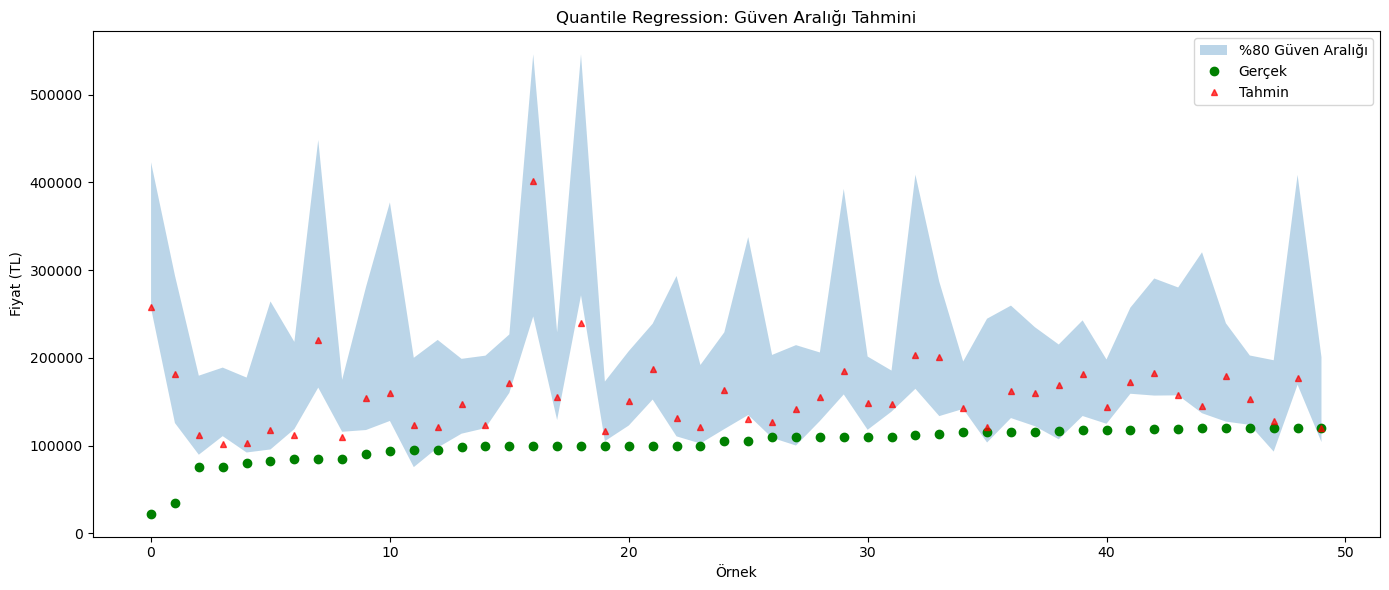

In [17]:
# Quantile modelleri PARALEL eğit
print("📈 QUANTILE REGRESSION MODELLERİ (Paralel Eğitim)")
print("=" * 60)

def train_quantile_model(alpha, name):
    """Quantile model eğit"""
    model_q = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=alpha,
        n_estimators=500,  # Azaltıldı
        learning_rate=0.1,  # Artırıldı
        max_depth=5,
        tree_method='hist',
        enable_categorical=True,
        n_jobs=N_JOBS // 2,  # CPU paylaş
        random_state=42,
        early_stopping_rounds=30
    )
    model_q.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return model_q, name

# Paralel eğitim
from concurrent.futures import ThreadPoolExecutor
import time

start = time.time()
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [
        executor.submit(train_quantile_model, 0.1, 'lower'),
        executor.submit(train_quantile_model, 0.9, 'upper')
    ]
    results = [f.result() for f in futures]

model_lower = results[0][0]
model_upper = results[1][0]
print(f"✅ Her iki model paralel eğitildi! ({time.time()-start:.1f} sn)")

# Tahminler
y_lower = np.expm1(model_lower.predict(X_val))
y_upper = np.expm1(model_upper.predict(X_val))
y_median = y_val_pred

# Kapsama oranı kontrolü
coverage = ((y_val_actual >= y_lower) & (y_val_actual <= y_upper)).mean() * 100
print(f"\n📊 %80 GÜVENİLİRLİK ARALIĞI SONUÇLARI:")
print(f"   Kapsama oranı: {coverage:.1f}% (hedef: ~80%)")
print(f"   Ortalama aralık genişliği: {(y_upper - y_lower).mean():,.0f} TL")

# Görselleştirme (ilk 50 örnek)
fig, ax = plt.subplots(figsize=(14, 6))
idx = np.argsort(y_val_actual.values)[:50]

ax.fill_between(range(50), y_lower[idx], y_upper[idx], alpha=0.3, label='%80 Güven Aralığı')
ax.plot(range(50), y_val_actual.values[idx], 'go', markersize=6, label='Gerçek')
ax.plot(range(50), y_median[idx], 'r^', markersize=4, alpha=0.7, label='Tahmin')
ax.set_xlabel('Örnek')
ax.set_ylabel('Fiyat (TL)')
ax.set_title('Quantile Regression: Güven Aralığı Tahmini')
ax.legend()
plt.tight_layout()
plt.show()

## 🏆 6. Yöntem 5: Segment Bazlı Özel Modeller (Fine-Tuning)

Her fiyat segmenti için ayrı model eğiterek uzmanlaşma sağlıyoruz.

## 🧹 4. Segment İçi Aykırı Değer İşlemleri & Robust Scaling

Her segmentte aykırı değerleri tespit edip, robust scaler veya winsorization uygulayarak modelin uç değerlerden daha az etkilenmesini sağlayacağız.

In [18]:
from sklearn.preprocessing import RobustScaler
import scipy.stats as stats

# Segment bazlı aykırı değer tespiti ve winsorization
X_train_scaled = X_train.copy()

for segment in ['0-500K', '500K-1M', '1M-2M', '2M-5M', '5M+']:
    mask = (pd.cut(np.expm1(y_train), 
                   bins=[0, 500000, 1000000, 2000000, 5000000, np.inf],
                   labels=['0-500K', '500K-1M', '1M-2M', '2M-5M', '5M+']) == segment)
    if mask.sum() < 100:
        continue
    print(f"\nSegment: {segment} ({mask.sum()} satır)")
    # Sadece numerik kolonlar
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    # Winsorization (uç değerleri kırp)
    for col in num_cols:
        col_data = X_train.loc[mask, col]
        # 1. ve 99. persentil arası ile sınırla
        lower, upper = np.percentile(col_data, 1), np.percentile(col_data, 99)
        X_train_scaled.loc[mask, col] = np.clip(col_data, lower, upper)
    # RobustScaler uygula
    scaler = RobustScaler()
    X_train_scaled.loc[mask, num_cols] = scaler.fit_transform(X_train_scaled.loc[mask, num_cols])
    print(f"   Numerik kolonlar robust scale edildi ve winsorize edildi.")

print("\n✅ Segment içi aykırı değer işlemleri tamamlandı. Model eğitiminde X_train_scaled kullanılabilir.")


Segment: 0-500K (13263 satır)
   Numerik kolonlar robust scale edildi ve winsorize edildi.

Segment: 500K-1M (4832 satır)
   Numerik kolonlar robust scale edildi ve winsorize edildi.

Segment: 1M-2M (1581 satır)
   Numerik kolonlar robust scale edildi ve winsorize edildi.

Segment: 2M-5M (855 satır)
   Numerik kolonlar robust scale edildi ve winsorize edildi.

✅ Segment içi aykırı değer işlemleri tamamlandı. Model eğitiminde X_train_scaled kullanılabilir.


## 🧩 5. Dinamik Segmentleme (K-Means ile Fiyat Kümeleme)

Fiyat segmentlerini sabit aralıklar yerine, k-means ile veri dağılımına göre otomatik belirleyeceğiz.

In [ ]:
from sklearn.cluster import KMeans

# Fiyatları log-scale'e alıp kümeliyoruz (daha dengeli segmentler için)
log_prices = y_train.values.reshape(-1, 1)
log_prices = np.log1p(np.expm1(log_prices))

n_segments = 5  # Kaç segment istiyorsan
kmeans = KMeans(n_clusters=n_segments, random_state=42)
clusters = kmeans.fit_predict(log_prices)

# Her satıra segment ataması
X_train_scaled['dynamic_segment'] = clusters

# Segment sınırlarını göster
centers = np.sort(np.expm1(kmeans.cluster_centers_.flatten()))
print("Dinamik segment merkezleri (TL):", centers.astype(int))

# Her segmentte kaç örnek var?
(unique, counts) = np.unique(clusters, return_counts=True)
for seg, cnt in zip(unique, counts):
    print(f"Segment {seg}: {cnt} örnek")

print("\n✅ Dinamik segmentler oluşturuldu. Model eğitiminde 'dynamic_segment' kullanılabilir.")

In [7]:
# Segment bazlı modeller - PARALEL EĞİTİM
print("🏆 SEGMENT BAZLI ÖZEL MODELLER (Paralel)")
print("=" * 60)

# Fiyat segmentlerini train set'e ekle
y_train_actual = np.expm1(y_train)
train_segments = pd.cut(y_train_actual, 
    bins=[0, 500000, 1000000, 2000000, 5000000, np.inf],
    labels=['0-500K', '500K-1M', '1M-2M', '2M-5M', '5M+'])

def train_segment_model(segment, X_train, y_train, X_val, y_val, train_segments, analysis_df):
    """Tek segment için model eğit"""
    train_mask = train_segments == segment
    val_mask = analysis_df['price_segment'] == segment
    
    if train_mask.sum() < 100:
        return None
    
    X_seg_train = X_train[train_mask]
    y_seg_train = y_train[train_mask]
    X_seg_val = X_val[val_mask.values]
    y_seg_val = y_val[val_mask.values]
    
    # Hızlı segment modeli
    seg_model = xgb.XGBRegressor(
        n_estimators=500,  # Azaltıldı
        learning_rate=0.1,  # Artırıldı
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.7,
        tree_method='hist',
        enable_categorical=True,
        n_jobs=N_JOBS // 5,  # CPU paylaş
        random_state=42,
        early_stopping_rounds=30
    )
    
    seg_model.fit(X_seg_train, y_seg_train, 
                  eval_set=[(X_seg_val, y_seg_val)], verbose=False)
    
    # Sonuçlar
    seg_pred = np.expm1(seg_model.predict(X_seg_val))
    seg_actual = np.expm1(y_seg_val)
    seg_r2 = r2_score(seg_actual, seg_pred)
    seg_pct_err = np.mean(np.abs(seg_actual - seg_pred) / seg_actual * 100)
    
    orig_preds = analysis_df.loc[val_mask, 'predicted'].values
    orig_r2 = r2_score(seg_actual, orig_preds)
    orig_pct_err = np.mean(np.abs(seg_actual - orig_preds) / seg_actual * 100)
    
    return {
        'segment': segment,
        'model': seg_model,
        'N_train': train_mask.sum(),
        'N_val': val_mask.sum(),
        'Orig_R²': orig_r2,
        'New_R²': seg_r2,
        'Orig_Err%': orig_pct_err,
        'New_Err%': seg_pct_err
    }

# Tüm segmentleri PARALEL eğit
import time
segments = ['0-500K', '500K-1M', '1M-2M', '2M-5M', '5M+']

start = time.time()
results = Parallel(n_jobs=5, prefer="threads")(
    delayed(train_segment_model)(seg, X_train, y_train, X_val, y_val, train_segments, analysis_df)
    for seg in segments
)
print(f"⚡ Tüm segmentler paralel eğitildi! ({time.time()-start:.1f} sn)")

# Sonuçları topla
segment_models = {}
segment_results = []
for res in results:
    if res:
        segment_models[res['segment']] = res['model']
        segment_results.append({k: v for k, v in res.items() if k != 'model'})
        print(f"✅ {res['segment']}: R² {res['Orig_R²']:.3f} → {res['New_R²']:.3f} | Hata% {res['Orig_Err%']:.1f} → {res['New_Err%']:.1f}")

# Özet tablo
print("\n📊 SEGMENT MODEL KARŞILAŞTIRMASI:")
results_df = pd.DataFrame(segment_results)
print(results_df.to_string(index=False))

🏆 SEGMENT BAZLI ÖZEL MODELLER (Paralel)
⚡ Tüm segmentler paralel eğitildi! (7.7 sn)
✅ 0-500K: R² 0.639 → 0.727 | Hata% 13.8 → 13.7
✅ 500K-1M: R² 0.109 → 0.430 | Hata% 13.4 → 11.6
✅ 1M-2M: R² -0.312 → 0.265 | Hata% 15.8 → 12.0
✅ 2M-5M: R² 0.503 → 0.513 | Hata% 15.1 → 15.8

📊 SEGMENT MODEL KARŞILAŞTIRMASI:
segment  N_train  N_val   Orig_R²   New_R²  Orig_Err%  New_Err%
 0-500K    13263   4411  0.638848 0.727134  13.755648 13.731421
500K-1M     4832   1590  0.109360 0.429967  13.389054 11.597947
  1M-2M     1581    502 -0.311949 0.264526  15.849909 11.999827
  2M-5M      855    340  0.503025 0.512824  15.066123 15.762426


## 📊 7. Final Özet ve Öneriler

In [8]:
print("=" * 70)
print("🏆 MODEL İYİLEŞTİRME ÖZETİ")
print("=" * 70)

print("""
📌 MEVCUT DURUM:
   • R² = %93.06
   • Medyan Hata = %10.24
   • Ortalama Hata = %13.89

📌 UYGULANAN YÖNTEMLER:

1️⃣ SEGMENT BAZLI DÜZELTME FAKTÖRLERİ
   ✓ Avantaj: Hızlı, kolay uygulanır
   ✓ Ne zaman: Segment bazlı sistematik bias varsa
   
2️⃣ AYKIRI DEĞER TESPİTİ + GÜVEN SKORU
   ✓ Avantaj: Belirsiz tahminleri işaretler
   ✓ Ne zaman: Kullanıcıya güvenilirlik göstermek istiyorsanız
   
3️⃣ RESİDUAL MODEL (HATA DÜZELTME)
   ✓ Avantaj: Sistematik hataları öğrenir
   ✓ Ne zaman: Model tutarlı hatalar yapıyorsa
   
4️⃣ QUANTILE REGRESSION
   ✓ Avantaj: Güven aralığı verir (alt-üst sınır)
   ✓ Ne zaman: Belirsizliği göstermek önemliyse

5️⃣ SEGMENT BAZLI ÖZEL MODELLER
   ✓ Avantaj: Her segment için uzmanlaşmış model
   ✓ Ne zaman: Segmentler arası davranış çok farklıysa

📌 ÖNERİLER:
   1. Aykırı değerlerin çoğu 5M+ segmentinde - bu segment için daha fazla veri gerekli
   2. Segment düzeltme faktörlerini production'da kullanabilirsiniz
   3. Quantile regression ile fiyat aralığı (min-max) sunabilirsiniz
   4. Güven skoru düşük tahminler için "yaklaşık değer" uyarısı gösterin
""")

# Threshold metrikleri karşılaştırması
def calc_thresholds(actual, pred):
    errors = np.abs(actual - pred) / actual * 100
    return {
        '±5%': (errors <= 5).mean() * 100,
        '±10%': (errors <= 10).mean() * 100,
        '±15%': (errors <= 15).mean() * 100,
        '±20%': (errors <= 20).mean() * 100,
    }

print("\n📊 THRESHOLD METRİKLERİ KARŞILAŞTIRMASI:")
print("-" * 50)
orig_thresh = calc_thresholds(y_val_actual, y_val_pred)
corr_thresh = calc_thresholds(y_val_actual, y_val_corrected)

for key in orig_thresh:
    print(f"{key}: Orijinal {orig_thresh[key]:.1f}% → Residual düzeltme {corr_thresh[key]:.1f}%")

🏆 MODEL İYİLEŞTİRME ÖZETİ

📌 MEVCUT DURUM:
   • R² = %93.06
   • Medyan Hata = %10.24
   • Ortalama Hata = %13.89

📌 UYGULANAN YÖNTEMLER:

1️⃣ SEGMENT BAZLI DÜZELTME FAKTÖRLERİ
   ✓ Avantaj: Hızlı, kolay uygulanır
   ✓ Ne zaman: Segment bazlı sistematik bias varsa
   
2️⃣ AYKIRI DEĞER TESPİTİ + GÜVEN SKORU
   ✓ Avantaj: Belirsiz tahminleri işaretler
   ✓ Ne zaman: Kullanıcıya güvenilirlik göstermek istiyorsanız
   
3️⃣ RESİDUAL MODEL (HATA DÜZELTME)
   ✓ Avantaj: Sistematik hataları öğrenir
   ✓ Ne zaman: Model tutarlı hatalar yapıyorsa
   
4️⃣ QUANTILE REGRESSION
   ✓ Avantaj: Güven aralığı verir (alt-üst sınır)
   ✓ Ne zaman: Belirsizliği göstermek önemliyse

5️⃣ SEGMENT BAZLI ÖZEL MODELLER
   ✓ Avantaj: Her segment için uzmanlaşmış model
   ✓ Ne zaman: Segmentler arası davranış çok farklıysa

📌 ÖNERİLER:
   1. Aykırı değerlerin çoğu 5M+ segmentinde - bu segment için daha fazla veri gerekli
   2. Segment düzeltme faktörlerini production'da kullanabilirsiniz
   3. Quantile regression 

## 💾 8. Modelleri Kaydet

In [11]:
# ============================================
# 🏆 EN İYİ MODELİ KAYDET (Orijinal + Residual Düzeltme)
# ============================================
import json
from datetime import datetime

print("💾 EN İYİ MODELİ KAYDETME")
print("=" * 60)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Final metrikler hesapla
final_r2 = r2_score(y_val_actual, y_val_corrected)
final_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_corrected))
final_mae = mean_absolute_error(y_val_actual, y_val_corrected)
final_pct_errors = np.abs(y_val_actual - y_val_corrected) / y_val_actual * 100

# Threshold metrikleri
thresholds = {
    "±5%": float((final_pct_errors <= 5).mean() * 100),
    "±10%": float((final_pct_errors <= 10).mean() * 100),
    "±15%": float((final_pct_errors <= 15).mean() * 100),
    "±20%": float((final_pct_errors <= 20).mean() * 100),
    "±25%": float((final_pct_errors <= 25).mean() * 100)
}

# ============================================
# COMBO MODEL: Orijinal + Residual birlikte kaydet
# ============================================
combo_models = {
    'base_model': model,           # Orijinal XGBoost
    'residual_model': residual_model  # Hata düzeltme modeli
}

model_filename = f'xgboost_improved_{timestamp}.joblib'
metadata_filename = f'xgboost_improved_{timestamp}_metadata.json'

# Modeli kaydet
joblib.dump(combo_models, model_filename)

# Metadata oluştur
metadata = {
    "model_type": "XGBoost + Residual Correction (Combo Model)",
    "description": "Orijinal model + hata düzeltme modeli birlikte",
    "created_at": datetime.now().isoformat(),
    "dataset": "hackathon_ultra_optimized.csv",
    "metrics": {
        "r2_score": float(final_r2),
        "rmse": float(final_rmse),
        "mae": float(final_mae),
        "median_error_pct": float(np.median(final_pct_errors)),
        "mean_error_pct": float(np.mean(final_pct_errors))
    },
    "threshold_metrics": thresholds,
    "parameters": {
        "base_model": model.get_params(),
        "residual_model": residual_model.get_params()
    },
    "training_info": {
        "n_features": X_train.shape[1],
        "n_train_samples": len(X_train),
        "n_val_samples": len(X_val),
        "base_model_iterations": model.best_iteration if hasattr(model, 'best_iteration') else "N/A",
        "residual_model_iterations": residual_model.best_iteration
    },
    "feature_columns": list(X_train.columns),
    "usage": """
# KULLANIM ÖRNEĞİ:
import joblib
import numpy as np

# Modeli yükle
models = joblib.load('xgboost_improved_XXXXXX.joblib')
base_model = models['base_model']
residual_model = models['residual_model']

# Tahmin yap
def predict_price(X):
    # 1. Orijinal model ile log fiyat tahmin et
    log_pred = base_model.predict(X)
    
    # 2. Residual model ile düzeltme yap
    residual_correction = residual_model.predict(X)
    
    # 3. Düzeltilmiş log fiyat
    corrected_log_pred = log_pred + residual_correction
    
    # 4. Gerçek fiyata çevir
    price = np.expm1(corrected_log_pred)
    return price

# Örnek kullanım:
# fiyat = predict_price(X_new)
"""
}

# Metadata kaydet
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"\n✅ MODEL KAYDEDİLDİ!")
print(f"=" * 60)
print(f"📁 Model dosyası: {model_filename}")
print(f"📁 Metadata dosyası: {metadata_filename}")
print(f"\n📊 PERFORMANS:")
print(f"   R² Score: {final_r2:.4f} ({final_r2*100:.2f}%)")
print(f"   RMSE: {final_rmse:,.0f} TL")
print(f"   MAE: {final_mae:,.0f} TL")
print(f"   Medyan Hata: {np.median(final_pct_errors):.2f}%")
print(f"   Ortalama Hata: {np.mean(final_pct_errors):.2f}%")
print(f"\n🎯 THRESHOLD METRİKLERİ:")
for k, v in thresholds.items():
    print(f"   {k}: {v:.1f}%")

print(f"""
\n{'='*60}
🚀 KULLANIM:
{'='*60}

import joblib
import numpy as np

# 1. Modeli yükle
models = joblib.load('{model_filename}')
base_model = models['base_model']
residual_model = models['residual_model']

# 2. Tahmin fonksiyonu
def predict_price(X):
    log_pred = base_model.predict(X)
    correction = residual_model.predict(X)
    return np.expm1(log_pred + correction)

# 3. Kullan
# fiyat = predict_price(X_new)
""")

💾 EN İYİ MODELİ KAYDETME

✅ MODEL KAYDEDİLDİ!
📁 Model dosyası: xgboost_improved_20251214_0957.joblib
📁 Metadata dosyası: xgboost_improved_20251214_0957_metadata.json

📊 PERFORMANS:
   R² Score: 0.9334 (93.34%)
   RMSE: 174,928 TL
   MAE: 85,043 TL
   Medyan Hata: 10.10%
   Ortalama Hata: 13.71%

🎯 THRESHOLD METRİKLERİ:
   ±5%: 27.2%
   ±10%: 49.6%
   ±15%: 67.3%
   ±20%: 79.0%
   ±25%: 86.2%


🚀 KULLANIM:

import joblib
import numpy as np

# 1. Modeli yükle
models = joblib.load('xgboost_improved_20251214_0957.joblib')
base_model = models['base_model']
residual_model = models['residual_model']

# 2. Tahmin fonksiyonu
def predict_price(X):
    log_pred = base_model.predict(X)
    correction = residual_model.predict(X)
    return np.expm1(log_pred + correction)

# 3. Kullan
# fiyat = predict_price(X_new)

